In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math 


mpl.rcParams['figure.dpi'] = 120

#### Settings

In [32]:
# 1 inch = 0.0254 m so approximatively 0.025 m
# 10 inches = 0.25m 
# 1 hectare = 10000m^2 therefore 100m*100m
# 100m = 0.25m*400 = 10in * 400 = 4000in

P_max = 1600 # Max number of dandelion heads
length = 50 # Shrunk from 400 to 50 therefore 80in by 80 in which is 1600 dandelions max
seeds_produced = (150+200)/2 # https://www.canr.msu.edu/weeds/extension/dandelion#:~:text=Seed%3A,because%20they%20move%20in%20updrafts.
survival_rate = (float) (0.02+0.04)/2
'''
 In one experiment, a majority of seeds were consumed by ground beetles within 2 to 3 weeks after shedding, 
 but the 2-4% of viable seeds that remained were sufficient to maintain high soil populations (Honek et al. 2005).
https://cals.cornell.edu/weed-science/weed-profiles/dandelion
'''

moisture_level = (float) (1) 
sunlight_level = (float) (1) # Sunlight stays constant throughout the year because we are considering avg sunlight 
sunlight_level_winter = (float) (0.9)
# https://www.researchgate.net/figure/Variation-of-sunshine-hours-with-months-of-the-year_fig1_268330578 - avg sunshine duration is 5h / day throughout the year
# Max sunshine level https://en.wikipedia.org/wiki/Sunshine_duration#:~:text=The%20city%20claiming%20the%20official,sunnier%20areas%20in%20North%20Africa: 11h/day on avg
# However, we will assume 1 is that plants get enough sunlight, and 0 is that they don't get any sunlight 0-1

avg_rain = 8 # per month, assuming that each day of precipitation grants 1 moisture
avg_iteration = 10 # n of iterations per month

#### Definitions

In [40]:
def set_wind(angle, wind):
    rad = math.radians(angle) # angle in deg
    relation = math.sin(rad)/math.cos(rad)
    print(relation)
    division_const = 3

    diagonal = [[0,0]]

    if (angle <= 45):

        for j in range(1, length+1):
            y = (int) ((j*relation))
            if (y >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([y, j])

            wind[y][j] = (float) ((j)/400)

        # Fill the rest

        #Proces upper diagonal 
        for j in range(length+1-1, -1, -1):
            for i in range(diagonal[j][0]+1, length+1):
                if (wind[i][j] == 0):
                    if (j+1 < length+1):
                        wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(i-diagonal[j][0]+1))

        #Process lower diagonal
        for j in range(1, length+1):
            for i in range(diagonal[j][0], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(diagonal[j][0]-i))
    elif angle > 45:

        for i in range(1, length+1):
            x = (int) ((i/relation))
            if (x >= length+1):
                diagonal.append([-1, -1])
                continue
            diagonal.append([i, x])

            wind[i][x] = (float) ((i+1)/400)
        
        #Process upper diagonal
        for i in range(1, length+1):
            for j in range(diagonal[i][1], -1, -1):
                if (wind[i][j] == 0):
                    wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/(2+(diagonal[i][1]-j))

        out = False

        #Process lower diagonal
        for i in range(length+1-1, -1, -1):
            for j in range(diagonal[i][1]+1, length+1):
                if (wind[i][j] == 0):
                    if (i+1 < length+1):
                        wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/(2+(j-diagonal[i][1]+1))


        

In [17]:
def show(land, moisture, sunlight, wind, title):
    fig, (ax1, ax2) = plt.subplots(2, 2)
    im1 = ax1[0].imshow(land, origin='lower')
    ax1[0].set_title("Land Plot")
    im2 = ax1[1].imshow(moisture, origin='lower')
    ax1[1].set_title("Moisture")
    im3 = ax2[0].imshow(sunlight, origin='lower')
    ax2[0].set_title("Sunlight")
    im4 = ax2[1].imshow(wind, origin='lower')
    ax2[1].set_title("Wind")
    fig.tight_layout(pad=1.0)
    fig.suptitle(title)

    count = 1
    for i in range(1, 3):
        for j in range(2):
            divider = make_axes_locatable(eval("ax"+str(i)+"["+str(j)+"]"))
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(eval("im"+str(count)), cax=cax)
            count+=1


    plt.show()

In [5]:
def grass_prop(x, y, land):
    return 1-(land[x][y]/P_max)

def dandelion_prop(x, y, land):
    return (land[x][y]/P_max)

In [33]:
def update_moisture(moisture, land):
    # first we update moisture

    for i in range(len(moisture)):
        for j in range(len(moisture)):
            moisture[i][j] = moisture[i][j]+avg_rain*((float) (1/avg_iteration)) # Take into account all the precipitation

    for i in range(len(land)):
        for j in range(len(land)):
            moisture[i][j] = max(moisture[i][j] - (dandelion_prop(i,j,land) * 0.9), 0.0)
            # print((grass_prop(i, j)*0.8) + (dandelion_prop(i,j) * 0.9))
            moisture[i][j] = min(moisture[i][j], 1.0) # bring back moisture to 0 - 1 range once adjusted 

In [26]:
def update_sunlight(sunlight, month):

    if month > 10 or month < 4:
        sunlight = np.full((length, length), sunlight_level_winter)
    else:
        sunlight = np.full((length, length), sunlight_level)

#### Variables

In [41]:

land = np.zeros((length, length))
land[0][0] = 1 #initial dandelion

# Defining wind as a NE direction for matrix
wind = np.zeros((length+1, length+1))
wind[0][0] = 0.001
set_wind(60, wind)
# Set length = length+1 to make it easier to calculate in the future 


moisture = np.full((length, length), moisture_level) 
sunlight = np.full((length, length), sunlight_level)

1.7320508075688767
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


#### Code

In [42]:
# print(len(wind[400]))

getout = False
count = 0

months = []

for month in range(1, 13):
    print("month ", month)

    for it in range(avg_iteration):
        # For each square, determine the number of seeds and check seed transfer based on the wind direction. 

        seeds = np.zeros((length, length)) 
        transfered_seeds = np.zeros((length, length)) # received seeds

        for i in range(length):
            for j in range(length):
                right = min(j+1, length) # Don't go out of bounds (doesn't happen but as backup)
                top = min(i+1, length)

                wind_sum = 0

                for y in range(2):
                    for x in range(2):
                        if (i+y < length and j+x<length):
                            wind_sum+=wind[i+y][j+x]


                total_seeds = seeds[i][j] + (int) (land[i][j]*seeds_produced*survival_rate)
                # seeds[i][j] += transfered_seeds[i][j]
                seeds[i][j] = round((wind[i][j]/wind_sum)*total_seeds)
                total_give = 0

                for y in range(2):
                    for x in range(2):
                        if (i+y < length and j+x<length):
                            seeds[i+y][j+x] = round((wind[i+y][j+x]/wind_sum)*total_seeds)

        #         count+=1
                
        #         if (count==1):
        #             getout = True
        #             break
        #     if getout:
        #         break
        # if getout: break

        # print(seeds)
        # Convert seeds to dandelions:

        for i in range(length):
            for j in range(length):
                land[i][j] = min(P_max, round((land[i][j]+seeds[i][j])*moisture[i][j]*sunlight[i][j]))
        
        update_moisture(moisture, land)
    update_sunlight(sunlight, month)

    months.append([land.copy(), moisture.copy(), sunlight.copy(), wind.copy()])
                
                
            


month  1
month  2
month  3
month  4
month  5
month  6
month  7
month  8
month  9
month  10
month  11
month  12


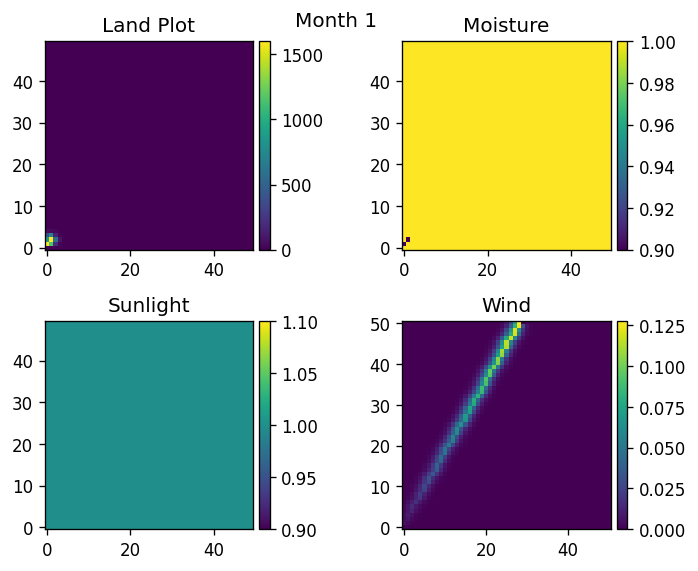

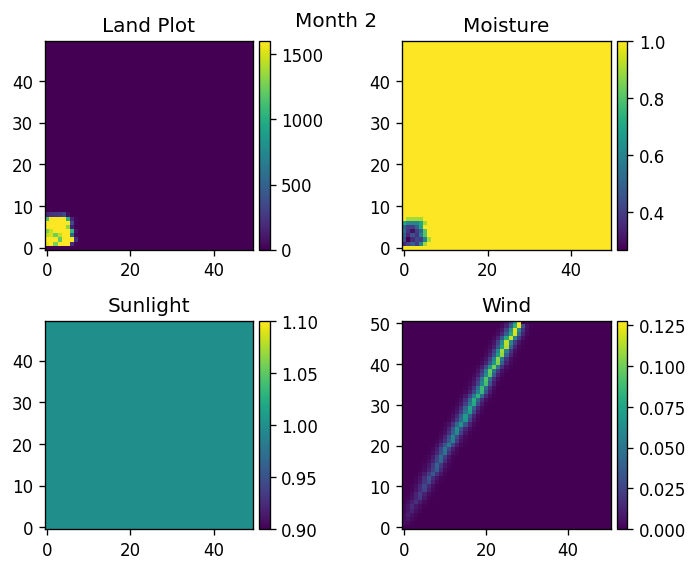

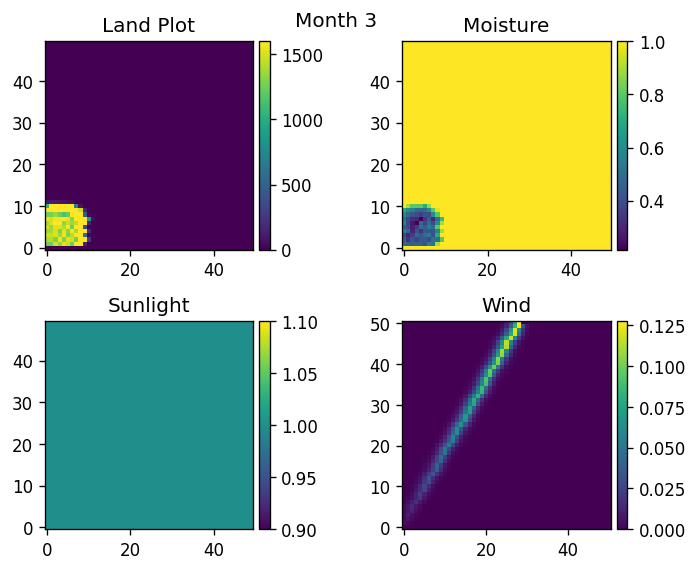

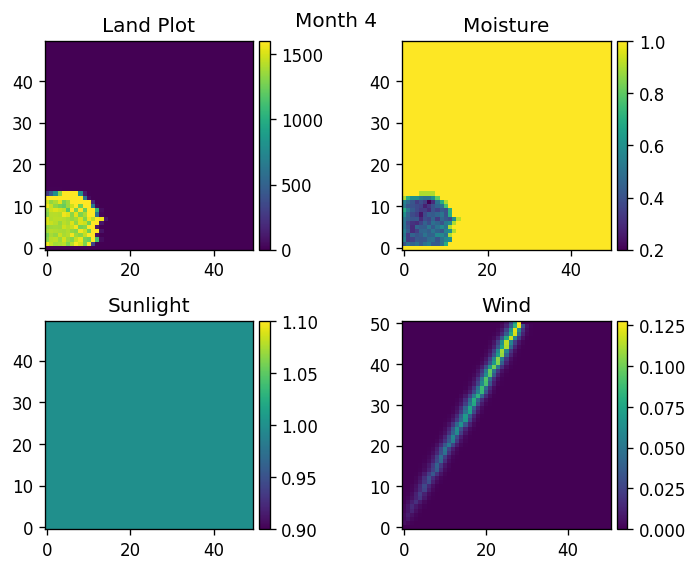

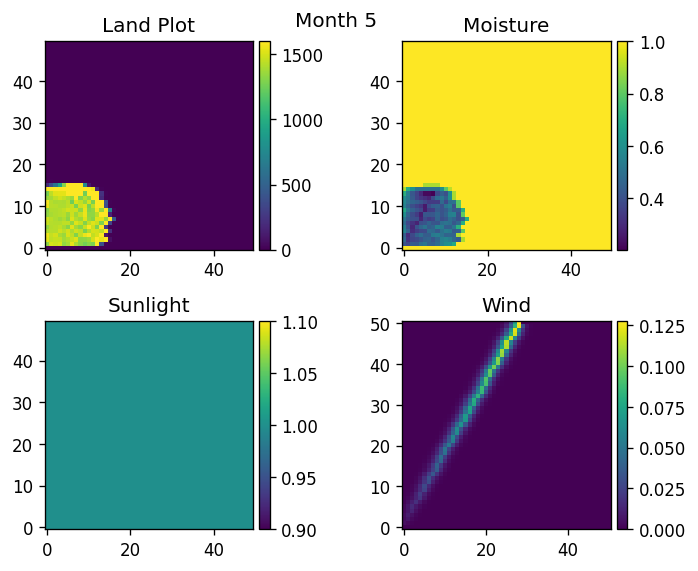

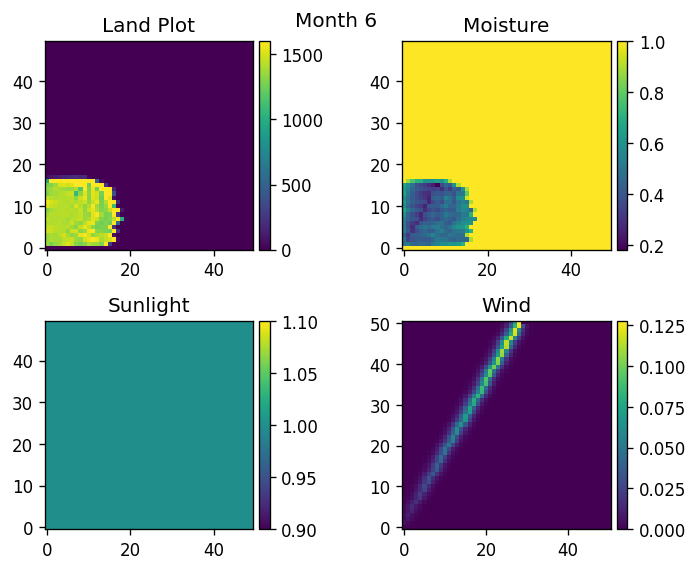

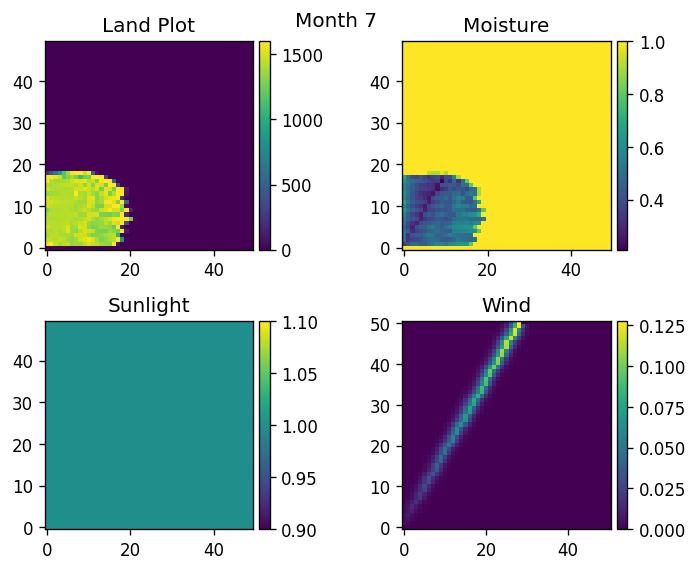

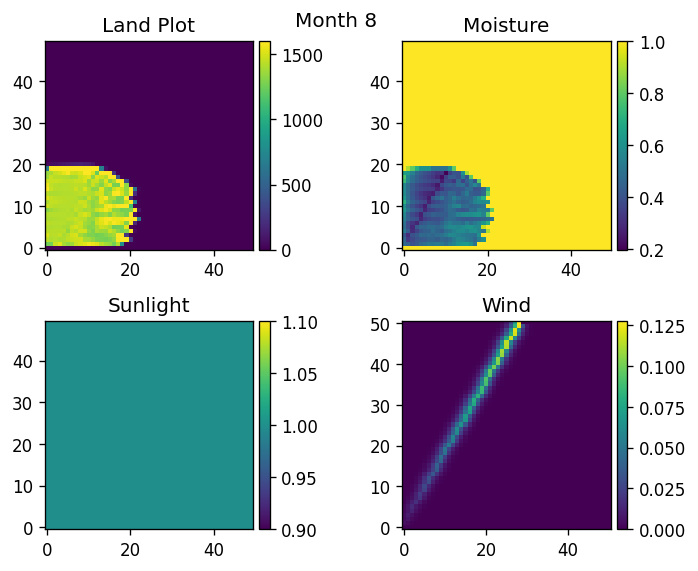

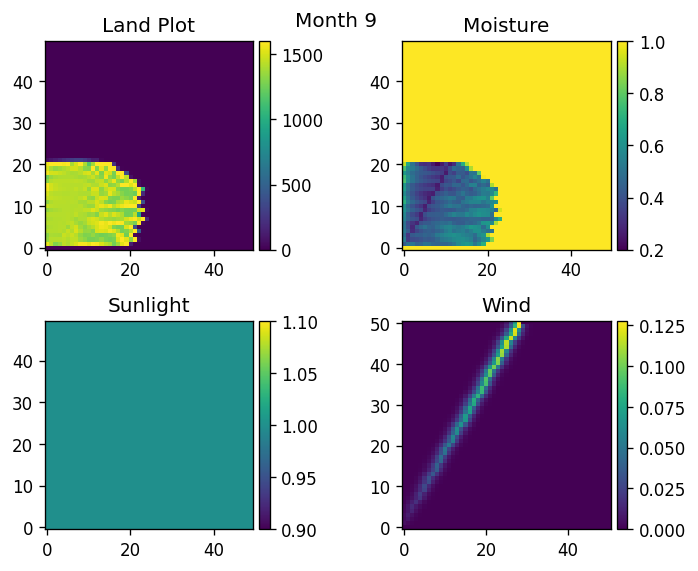

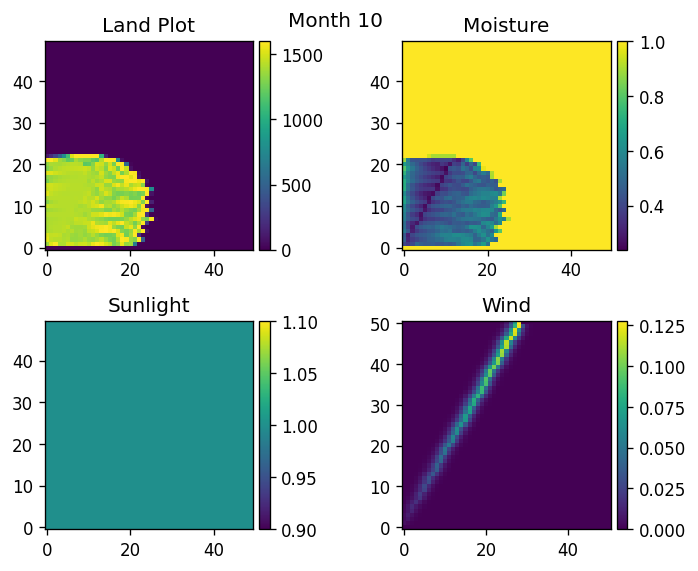

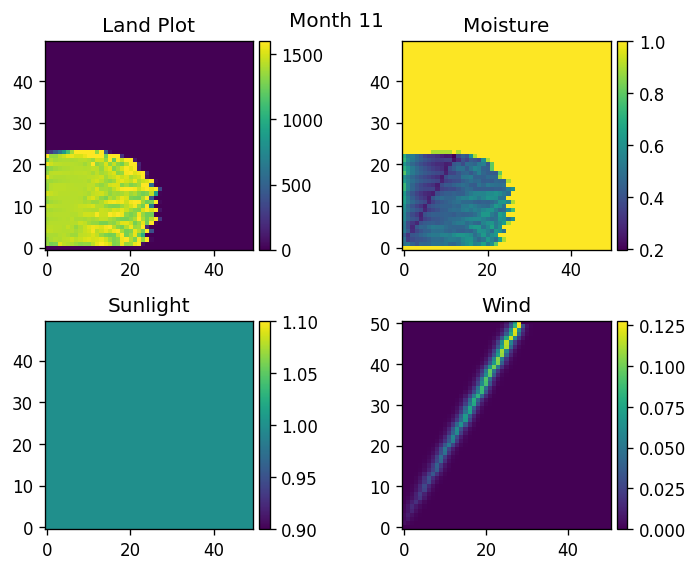

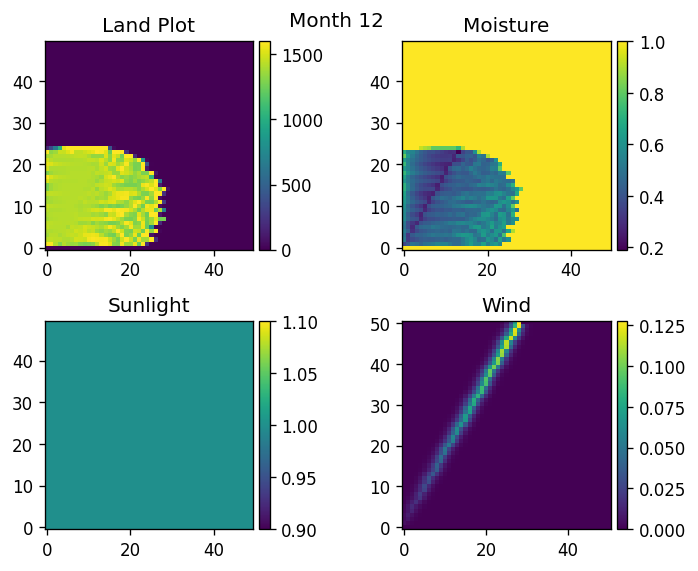

In [43]:
for i in range(len(months)):
    show(months[i][0], months[i][1], months[i][2], months[i][3], "Month "+str(i+1))